<h1 align="center">ID/X Loan Prediction</h1>


### Import Packages

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

from sklearn import metrics
from sklearn.metrics import (accuracy_score, f1_score,average_precision_score, confusion_matrix,
                             average_precision_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve,auc, ConfusionMatrixDisplay )
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import xgboost as xgb

# Imbalance Class Framework
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter

import category_encoders as ce
from pickle import dump

In [3]:
df = pd.read_csv("loan_data_2007_2014.csv", index_col=['id'])
df.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8064\4057457026.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan_data_2007_2014.csv", index_col=['id'])


,Unnamed: 0,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
id,,,,,,,,,,,,,,,,,,,,,
1077501,0,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1077430,1,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1077175,2,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1076863,3,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1075358,4,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df.columns

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'ac

### Confussion notes
#### Target class was not clear, but these features can potentially be used for the target:
1. grade (A-G): categorical
2. loan_status (varies): categorical
3. int_rate or interest rate: numerical (need treshold)

#### feature engineering
4. debt_to_income_ratio: numerical (need treshold) 

In [6]:
df['grade'].value_counts()

B    136929
C    125293
D     76888
A     74867
E     35757
F     13229
G      3322
Name: grade, dtype: int64

In [7]:
df['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [8]:
df['int_rate'].value_counts()

12.99    15846
10.99    14837
15.61    13074
8.90     11424
16.29    10587
         ...  
24.40        1
16.83        1
17.78        1
24.59        1
18.72        1
Name: int_rate, Length: 506, dtype: int64

In [9]:
pd.set_option('display.max_rows', 63)
df[['grade', 'loan_status']].value_counts()

grade  loan_status                                        
B      Current                                                64009
C      Current                                                63351
B      Fully Paid                                             60962
C      Fully Paid                                             45818
D      Current                                                37460
A      Fully Paid                                             36455
       Current                                                35191
D      Fully Paid                                             26089
E      Current                                                17229
C      Charged Off                                            11921
E      Fully Paid                                             10569
D      Charged Off                                             9748
B      Charged Off                                             9157
E      Charged Off                                       

In [10]:
df['int_rate'].describe()

count    466285.000000
mean         13.829236
std           4.357587
min           5.420000
25%          10.990000
50%          13.660000
75%          16.490000
max          26.060000
Name: int_rate, dtype: float64

### Inspect Data

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 1077501 to 9199665
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    466285 non-null  int64  
 1   loan_amnt                    466285 non-null  int64  
 2   funded_amnt                  466285 non-null  int64  
 3   funded_amnt_inv              466285 non-null  float64
 4   term                         466285 non-null  object 
 5   int_rate                     466285 non-null  float64
 6   installment                  466285 non-null  float64
 7   grade                        466285 non-null  object 
 8   sub_grade                    466285 non-null  object 
 9   emp_title                    438697 non-null  object 
 10  emp_length                   445277 non-null  object 
 11  home_ownership               466285 non-null  object 
 12  annual_inc                   466281 non-null  float

In [12]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,466256.000000,466256.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,0.284678,0.804745,...,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,0.797365,1.091598,...,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,3.790000e+04,NaN,NaN,NaN
max,4.086083e+07,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,29.000000,33.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,9.999999e+06,NaN,NaN,NaN


### Check for empty values

In [13]:
pd.set_option('display.max_rows', 73)
df.isnull().sum()

member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       27588
emp_length                      21008
home_ownership                      0
annual_inc                          4
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           340302
purpose                             0
title                              20
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        29
earliest_cr_line                   29
inq_last_6mt

### Target Feature Engineering(1): approved (1 or 0)
Given the list of values for the feature loan_status and the list of feature values of grade, the combination of these features can be used to predict whether a loan application will be approved or rejected.

Based on past decisions, the values for the feature loan_status that correspond to a loan application being approved are 'Current' and 'Fully Paid'. These values indicate that the borrower has made all of their payments on time and the loan is still active or has been fully repaid. And the feature values of grade that correspond to a loan application being approved are typically A, B, and C. These values indicate that the borrower has a high credit score and a low risk of default.

On the other hand, the values that correspond to a loan application being rejected are 'Charged Off', 'Default', 'Does not meet the credit policy. Status: Charged Off', 'Late' and 'In Grace Period' are not explicit rejection, but it could be considered as a warning for the borrower, and could be used as a feature for the model to predict the risk of default. And the feature values that correspond to a loan application being rejected are typically D, E, F, and G. These values indicate that the borrower has a lower credit score and a higher risk of default.

It's important to note that this is a general guideline and the specific approach will depend on the business requirements and the goals of the project. The lender may have different standards and criteria, and it's possible that a borrower with a lower grade or a warning status may still be approved for a loan if they have other positive factors such as a high income or a low debt-to-income ratio.

It's also important to consider the distribution of the values for the feature loan_status and grade in the dataset, if the dataset is unbalanced, where the majority of the data belongs to one class, it could impact the performance of the model. Therefore, it's important to balance the dataset or use techniques such as oversampling or undersampling to handle the imbalance.

In summary, the values of loan_status 'Current' and 'Fully Paid' and feature values of grade A, B, and C correspond to a loan application being approved, while the values 'Charged Off', 'Default', 'Does not meet the credit policy. Status: Charged Off', 'Late' and 'In Grace Period' and the feature values of grade D, E, F, and G correspond to a loan application being rejected. However, it's important to consider the specific business requirements, the distribution of the data in the dataset and the combination of features used in the model.

### Flowchart
<code>
if loan_status = ['Current', 'Fully Paid']: 
   approved 
else: 
    if grade = ['A','B']: 
        approved 
    else: 
        if grade = 'C' AND debt_to_income_ratio < treshold:
            approved 
        else: 
            rejected 
 </code>

### Test Dataset for Approval Functions

In [14]:
data = pd.DataFrame({'loan_status': ['Current', 'Fully Paid', 'Default', 'Late', 'Late', 'Default', 'Fully Paid', 'Late', 'Late'], 'grade':['C','A','A','D','C','A','A', 'C', 'F'], 'dti':[10,20,30,40,30,50, 100, 30, 30]})
data

,loan_status,grade,dti
0,Current,C,10
1,Fully Paid,A,20
2,Default,A,30
3,Late,D,40
4,Late,C,30
5,Default,A,50
6,Fully Paid,A,100
7,Late,C,30
8,Late,F,30


In [15]:
def generate_approval_feature(df, loan_status_column, grade_column, debt_to_income_column, threshold=0):
    """
    This function generate df['approved'] feature for pd.DataFrame
    
      Parameters:
    - df (pd.DataFrame): The DataFrame containing the loan_status, grade, and debt_to_income_ratio_in_month data.
    - loan_status_column (str): The name of the column in the DataFrame that contains the loan status data.
    - grade_column (str): The name of the column in the DataFrame that contains the grade data.
    - debt_to_income_column (str): The name of the column in the DataFrame that contains the debt data.
    - threshold (int): The threshold for debt_to_income for the application to be approved, default to 0. can also be 'mean'
    
    Returns:
    - pd.DataFrame: The input DataFrame with an added column for the debt to income ratio.
    
    """
    # accepted parameters
    acceptable_loan_statuses = ["Fully Paid", "Current"]
    # vectorized implementations for faster computations
    # (1) if loan status == ["Fully Paid", "Current"] approved
    df["approved"] = np.where(df[loan_status_column].isin(acceptable_loan_statuses), 1, 0)
    # (2) if loan status != ["Fully Paid", "Current"], but grade == ["A", "B"] still approved
    df["approved"] = np.where(df[grade_column].isin(["A","B"]), 1, df["approved"])
    # (3) if grade == "C", but debt_to_income_ratio_in_month < threshold approved
    if threshold == 'mean':
        threshold = df[debt_to_income_column].mean()
        df["approved"] = np.where((df[grade_column] == "C") & (df[debt_to_income_column] <= threshold), 1, df["approved"])
    else:
        df["approved"] = np.where((df[grade_column] == "C") & (df[debt_to_income_column] <= threshold), 1, df["approved"])

generate_approval_feature(data, 'loan_status', 'grade', 'dti', 'mean')

In [16]:
data['dti'].mean()

37.77777777777778

In [17]:
data

,loan_status,grade,dti,approved
0,Current,C,10,1
1,Fully Paid,A,20,1
2,Default,A,30,1
3,Late,D,40,0
4,Late,C,30,1
5,Default,A,50,1
6,Fully Paid,A,100,1
7,Late,C,30,1
8,Late,F,30,0


### Generate approved feature on the real dataset

In [18]:
generate_approval_feature(df, 'loan_status', 'grade', 'dti', 'mean')

In [19]:
df['approved'].value_counts(dropna=False)

1    431421
0     34864
Name: approved, dtype: int64

### The target class is imbalanced, so we need to 
1. Use the proper evaluation metrics such as Precision, Recall, F1, AUC score to evaluate our model
2. Oversampling or Undersampling the data to reduce bias (underfitting) in the minority class

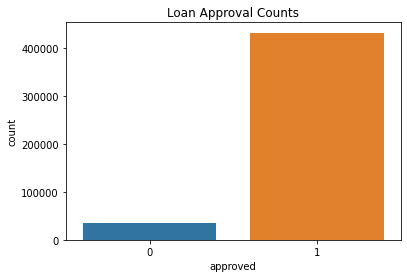

In [20]:
# Create the bar plot
sns.countplot(x='approved', data=df)

# Add a title
plt.title("Loan Approval Counts")

# Show the plot
plt.show()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 1077501 to 9199665
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    466285 non-null  int64  
 1   loan_amnt                    466285 non-null  int64  
 2   funded_amnt                  466285 non-null  int64  
 3   funded_amnt_inv              466285 non-null  float64
 4   term                         466285 non-null  object 
 5   int_rate                     466285 non-null  float64
 6   installment                  466285 non-null  float64
 7   grade                        466285 non-null  object 
 8   sub_grade                    466285 non-null  object 
 9   emp_title                    438697 non-null  object 
 10  emp_length                   445277 non-null  object 
 11  home_ownership               466285 non-null  object 
 12  annual_inc                   466281 non-null  float

In [22]:
pd.set_option('display.max_rows', 75)
df.nunique()

member_id                      466285
loan_amnt                        1352
funded_amnt                      1354
funded_amnt_inv                  9854
term                                2
int_rate                          506
installment                     55622
grade                               7
sub_grade                          35
emp_title                      205475
emp_length                         11
home_ownership                      6
annual_inc                      31901
verification_status                 3
issue_d                            91
loan_status                         9
pymnt_plan                          2
url                            466285
desc                           124436
purpose                            14
title                           63099
zip_code                          888
addr_state                         50
dti                              3997
delinq_2yrs                        24
earliest_cr_line                  664
inq_last_6mt

### Feature Selection
For predicting on new data or future data we need to consider specific features:
- Features that will only be available in borrower application: some features like loan_status, grade, funded_amount might not be available, since the borrower is not having loan yet. 
- Features that doesn't have too many unique, duplicate, or missing values


#### And that features are:
#### Numeric
- loan_amnt: the amound of loan
- int_rate: interest rate
- empl_length: employment length on years (0 to 10)
- annual_inc: annual income
- dti: debt to income ratio, a ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- delinq: delinquent, the current number of accounts where the borrower is behind on payments. It gives an indication of the borrower's ability to manage their finances and make timely payments on their debts.
- revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- approved: whether the loan is approved or not (1 or 0)

#### Categorical
- home_ownership: the status on home ownership
- pymnt_plan: whether or not the borrower has chosen to enroll in a payment plan. Typically, if the value is "y" it stands for "yes", the borrower has enrolled in a payment plan, and if the value is "n" it stands for "no", the borrower has not enrolled in a payment plan.
- purpose: a category provided by the borrower for the loan request. 
- addr_state: state address
- zip code: the first 3 numbers of the zip code provided by the borrower in the loan application.

#### optional features(NLP tasks):
Usually contains a sequence of text that can be analyze using specific machine learning technique, these feature are:
- desc: loan description provided by the borrower

In [23]:
features_selection=['loan_amnt','dti', 'int_rate', 'emp_length','annual_inc', 'dti', 'delinq_2yrs', 'acc_now_delinq', 'revol_util', 'home_ownership','pymnt_plan', 'purpose', 'addr_state', 'approved']
categorical_features=['emp_length','home_ownership','pymnt_plan', 'purpose', 'addr_state']

In [24]:
print("total selected features: ", len(features_selection))
print("total categorical features", len(categorical_features))

total selected features:  14
total categorical features 5


In [25]:
# get data frame for feature selection
# df_fs: data frame of features selection
df_fs = df[features_selection].copy()

In [26]:
df_fs.nunique()

loan_amnt          1352
dti                3997
int_rate            506
emp_length           11
annual_inc        31901
dti                3997
delinq_2yrs          24
acc_now_delinq        6
revol_util         1269
home_ownership        6
pymnt_plan            2
purpose              14
addr_state           50
approved              2
dtype: int64

### Handling missing values
The common threshold or proportion to drop rows with missing values can vary depending on the specific use case and the amount of missing data that can be tolerated. A common threshold is 20-30%, meaning that if more than 20-30% of the values in a row are missing, the row is dropped. However, this threshold can be higher or lower depending on the context and the specific requirements of the analysis.

In [27]:
df_fs.isnull().mean()

loan_amnt         0.000000
dti               0.000000
int_rate          0.000000
emp_length        0.045054
annual_inc        0.000009
dti               0.000000
delinq_2yrs       0.000062
acc_now_delinq    0.000062
revol_util        0.000729
home_ownership    0.000000
pymnt_plan        0.000000
purpose           0.000000
addr_state        0.000000
approved          0.000000
dtype: float64

In [28]:
# drop all rows that has missing values
df_fs.dropna(axis=0, inplace=True)

In [29]:
df_fs.isnull().sum()

loan_amnt         0
dti               0
int_rate          0
emp_length        0
annual_inc        0
dti               0
delinq_2yrs       0
acc_now_delinq    0
revol_util        0
home_ownership    0
pymnt_plan        0
purpose           0
addr_state        0
approved          0
dtype: int64

In [30]:
df_fs.shape

(444949, 14)

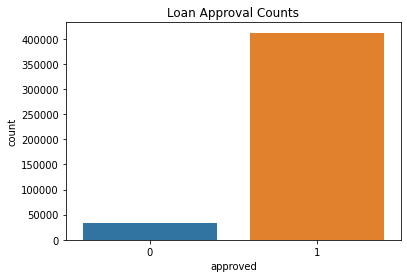

In [31]:
# Create the bar plot
sns.countplot(x='approved', data=df_fs)

# Add a title
plt.title("Loan Approval Counts")

# Show the plot
plt.show()

### EDA

### Encode Categorical Data
There is no single best encoding technique for all datasets, the best encoding technique will depend on the characteristics of your dataset and the specific problem you are trying to solve. However, when dealing with imbalanced dataset and loan prediction problem, there are some encoding techniques that are particularly well-suited:

- The Weight of Evidence (WOE) Encoding: This is a technique for encoding categorical variables that is particularly useful for datasets with imbalanced classes. It works by replacing each category with the log ratio of the probability of the target variable being 1 for that category to the probability of the target variable being 0. This helps to highlight the relationship between each category and the target variable, and can be particularly useful for datasets with imbalanced classes.

- Target Encoding: This technique encodes categorical variables by replacing each category with the average value of the target variable for that category. This can help to reduce the number of unique categories and provide more robust feature encoding. Target encoding can be a good choice when dealing with imbalanced datasets, because it can help to highlight the relationship between each category and the target variable.

- LeaveOneOut Encoding: This is a technique for encoding categorical variables that is similar to target encoding. It works by replacing each category with the average value of the target variable for all examples in the dataset, except for the one being encoded. This can help to reduce the number of unique categories and provide more robust feature encoding. LeaveOneOut Encoding can be a good choice when dealing with imbalanced

Im going to choose Target Encoding (TE)

In [32]:
X = df_fs.loc[:, df_fs.columns][categorical_features]
y = df_fs.approved

te_encoder = ce.TargetEncoder(cols=categorical_features)
te_encoder.fit(X, y)

dump(te_encoder, open('te_encoder.pkl', 'wb')) # save te_encoder

X_encoded = te_encoder.transform(X).astype('float32')
X_encoded.columns = ['te_'+col for col in X_encoded.columns]

# concat with features selection dataframe
# and drop old categorical data
df_fs_enc = pd.concat([df_fs, X_encoded], axis=1).drop(categorical_features, axis=1)

In [33]:
df_fs_enc.columns

Index(['loan_amnt', 'dti', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'acc_now_delinq', 'revol_util', 'approved', 'te_emp_length',
       'te_home_ownership', 'te_pymnt_plan', 'te_purpose', 'te_addr_state'],
      dtype='object')

### Train - Validation - Test Split

Separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [34]:
df_fs_enc.shape

(444949, 14)

In [35]:
X = df_fs_enc.drop('approved', axis=1)
y = df_fs_enc.approved

# split the data using sklearn routine 
# we locked the random seed with random state = 42
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size=0.20, random_state=42, stratify=y)
#X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=42, stratify=y)
#X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=42, stratify=y_)

In [36]:
negative = (y_train==0).sum()
positive = (y_train==1).sum()
print(positive, negative)
print(positive+negative, len(y_train))

329470 26489
355959 355959


### Scaling
#### At what modelling step do we apply feature scaling?
It is important to mention that before applying any sort of data normalisation, we first need to split our initial dataset into training and testing sets. Don’t forget that testing data points represent real-world data.

Mean and standard deviation is taken into account when standardising our data. If we take the mean and variance of the whole dataset then we will be introducing future information into the training explanatory variables. Therefore, we should perform feature scaling over the training data and then perform normalisation on testing instances as well, but this time using the mean and standard deviation of training explanatory variables. In this way, we can test and evaluate whether our model can generalise well to new, unseen data points.

In [37]:
from sklearn.preprocessing import RobustScaler

# RobustScaler is less prone to outliers.
r_scaler = RobustScaler()

# Fit only to the training data
X_train_scaled = r_scaler.fit_transform(X_train)

dump(r_scaler, open('r_scaler.pkl', 'wb')) # save r_scaler

X_cv_scaled = r_scaler.transform(X_cv)
#X_test_scaled = r_scaler.transform(X_test)

### Baseline: Logistic Regression

In [38]:
model_baseline = LogisticRegression()
model_baseline.fit(X_train_scaled, y_train)
y_pred = model_baseline.predict(X_cv_scaled)
y_predtrain = model_baseline.predict(X_train_scaled)
CM_LR = confusion_matrix(y_cv,y_pred)
CR_LR = classification_report(y_cv,y_pred)
CM_LRtrain = confusion_matrix(y_train,y_predtrain)
CR_LRtrain = classification_report(y_train,y_predtrain)
print("Confusion Matrix Train:\n",CM_LRtrain)
print("Classification Report Train:\n",CR_LRtrain)
print("Confusion Matrix:\n",CM_LR)
print("Classification Report:\n",CR_LR)

Confusion Matrix Train:
 [[   634  25855]
 [  1538 327932]]
Classification Report Train:
               precision    recall  f1-score   support

           0       0.29      0.02      0.04     26489
           1       0.93      1.00      0.96    329470

    accuracy                           0.92    355959
   macro avg       0.61      0.51      0.50    355959
weighted avg       0.88      0.92      0.89    355959

Confusion Matrix:
 [[  209  6413]
 [  374 81994]]
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.03      0.06      6622
           1       0.93      1.00      0.96     82368

    accuracy                           0.92     88990
   macro avg       0.64      0.51      0.51     88990
weighted avg       0.89      0.92      0.89     88990



Since the class are imbalanced our model struggling to identify minority class "0"

### Precision - Recall curve

In [2]:
from sklearn.metrics import precision_recall_curve

Logistic: f1=0.058 auc=0.233


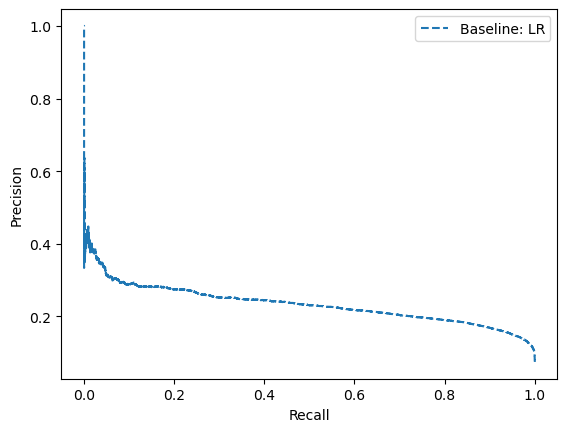

In [301]:
# predict probabilities
lr_probs = model_baseline.predict_proba(X_cv_scaled)
# keep probabilities for the negative outcome only
lr_probs = lr_probs[:, 0]
# predict class values
yhat = model_baseline.predict(X_cv_scaled)
# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_cv, lr_probs, pos_label=0)
# calculate scores
lr_f1, lr_auc = f1_score(y_cv, yhat, pos_label=0), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_cv[y_cv==0]) / len(y_cv)
#plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Baseline')
#plt.plot(lr_recall, lr_precision, marker='.', label='Baseline')
plt.plot(lr_recall, lr_precision, linestyle='--', label='Baseline: LR')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

For plotting let's prepare np.array to store precision and recall for each model

In [302]:
# create dictionary:models to store informations for plotting
models_info = []
model = {'model_name': 'Baseline: LR', 
         'precision':lr_precision, 
         'recall': lr_recall}
models_info.append(model)

### Create Model Utility Functions

In [42]:
def add_model_informations(models_info, model_name, precision, recall, f1=None):
    model = {'model_name': model_name, 
             'precision': precision, 
             'recall': recall,
             'f1': f1}
    models_info.append(model)

def compute_precision_recall(model, X_validation, y_validation, pos_label=0):
    """
    This function compute precision and recall from model
    
      Parameters:
    - model (sklearn.model): Model to evaluate
    - X_validation(list): List of X values for evaluation
    - y_validation(list): List of y labels for evaluation
    - pos_label: label of minority class (0 or 1) default to: 0
    
    Returns:
    - precisions (np.array) : list of precisions for every treshold
    - recalls (np.array) : list of recalls for every treshold
    """
    # predict probabilities
    model_probs = model.predict_proba(X_validation)
    # keep probabilities for the pos_label outcome only
    model_probs = model_probs[:, pos_label]
    # predict class values
    yhat = model.predict(X_validation)
    # calculate precision and recall for each threshold
    precision, recall, _ = precision_recall_curve(y_validation, model_probs, pos_label=pos_label)
    
    return precision, recall

def plot_precision_recall_curve(model_informations):
    for i in range(len(model_informations)):
        if i == 0:
            plt.plot(model_informations[i]['recall'], model_informations[i]['precision'], linestyle='--', label=model_informations[i]['model_name'])
        else:
            plt.plot(model_informations[i]['recall'], model_informations[i]['precision'], linestyle='-', label=model_informations[i]['model_name'])
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

### Improvement
From data:
- Resampling (Oversampling/Undersampling)
- Feature Engineering

From algorithm:
- Try different model
- Hyperparameter Tuning

### Resampling

In [304]:
Counter(y_train)

Counter({1: 329470, 0: 26489})

In [305]:
over = SMOTE(sampling_strategy=1)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train_resample, y_train_resample = pipeline.fit_resample(X_train_scaled, y_train)

In [306]:
Counter(y_train_resample)

Counter({0: 329470, 1: 329470})

### Logistic Regression: Resample(0.5, 0.5)

In [307]:
lr_resample = LogisticRegression()
lr_resample.fit(X_train_resample, y_train_resample)
y_pred = lr_resample.predict(X_cv_scaled)
y_predtrain = lr_resample.predict(X_train_resample)
CM_LR = confusion_matrix(y_cv,y_pred)
CR_LR = classification_report(y_cv,y_pred)
CM_LRtrain = confusion_matrix(y_train_resample,y_predtrain)
CR_LRtrain = classification_report(y_train_resample,y_predtrain)
print("Confusion Matrix Train:\n",CM_LRtrain)
print("Classification Report Train:\n",CR_LRtrain)
print("Confusion Matrix:\n",CM_LR)
print("Classification Report:\n",CR_LR)

Confusion Matrix Train:
 [[256686  72784]
 [ 84008 245462]]
Classification Report Train:
               precision    recall  f1-score   support

           0       0.75      0.78      0.77    329470
           1       0.77      0.75      0.76    329470

    accuracy                           0.76    658940
   macro avg       0.76      0.76      0.76    658940
weighted avg       0.76      0.76      0.76    658940

Confusion Matrix:
 [[ 5110  1512]
 [21179 61189]]
Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.77      0.31      6622
           1       0.98      0.74      0.84     82368

    accuracy                           0.75     88990
   macro avg       0.59      0.76      0.58     88990
weighted avg       0.92      0.75      0.80     88990



In [308]:
#append model_name:"LR: Resample" precision and recall
precision, recall = compute_precision_recall(lr_resample, X_cv_scaled, y_cv, pos_label=0)
add_model_informations(models_info, 'LR: Resample(0.5, 0.5)', precision, recall)

In [309]:
y_predict = lr_resample.predict(X_cv_scaled)
f1 = f1_score(y_cv, y_predict, pos_label=0)
f1

0.3105344717571633

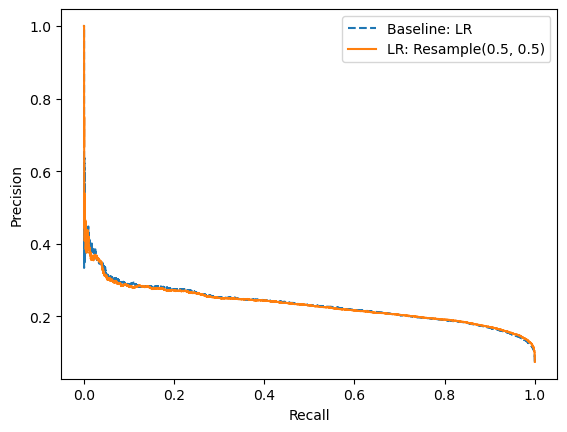

In [310]:
plot_precision_recall_curve(models_info)

### Logistic Regression: Resample (?, ?)

In [39]:
def tuning_resample_portion(X_train, y_train, X_cv, y_cv, model_type):
    models_info = []
    over_portions = [None, 1, 0.9, 0.8, 0.5, 0.5]
    under_portions = [None, 1, 1, 1, 0.9, 0.5]
    best_f1 = 0
    best_model = None
    for i in range(len(over_portions)):
        if over_portions[i] == None:
            
            if model_type == 'logistic':
                model = LogisticRegression()
                print("Processing - LR: Without Resample")
            elif model_type == 'rf':
                model = RandomForestClassifier()
                print("Processing - RF: Without Resample")
            elif model_type == 'xgb':
                model = xgb.XGBClassifier()
                print("Processing - XGB: Without Resample")
            
            model.fit(X_train, y_train)
            y_predict = model.predict(X_cv)
            
            f1 = f1_score(y_cv, y_predict, pos_label=0)
            if f1 > best_f1:
                best_f1 = f1
                print("Top F1 updated: ", best_f1)
                best_model = model
            print("F1 :", f1)
            precision, recall = compute_precision_recall(model, X_cv, y_cv, pos_label=0)
            
            if model_type == 'logistic':
                add_model_informations(models_info, 'LR: Without Resample F1({0:.4f})'.format(f1), precision, recall, f1)
            elif model_type == 'rf':
                add_model_informations(models_info, 'RF: Without Resample F1({0:.4f})'.format(f1), precision, recall, f1)
            elif model_type == 'xgb':
                add_model_informations(models_info, 'XGB: Without Resample F1({0:.4f})'.format(f1), precision, recall, f1)
        else:      
            over = SMOTE(sampling_strategy=over_portions[i])
            under = RandomUnderSampler(sampling_strategy=under_portions[i])
            steps = [('o', over), ('u', under)]
            pipeline = Pipeline(steps=steps)
            X_train_resample, y_train_resample = pipeline.fit_resample(X_train, y_train)
            
            if model_type == 'logistic':
                model = LogisticRegression()
                print("Processing - LR with ({}, {})".format(over_portions[i], under_portions[i]))
            elif model_type == 'rf':
                model = RandomForestClassifier()
                print("Processing - RF with ({}, {})".format(over_portions[i], under_portions[i]))
            elif model_type == 'xgb':
                model = xgb.XGBClassifier()
                print("Processing - XGB with ({}, {})".format(over_portions[i], under_portions[i]))
                    
            model.fit(X_train_resample, y_train_resample)
            y_predict = model.predict(X_cv)
            
            f1 = f1_score(y_cv, y_predict, pos_label=0)
            
            if f1 > best_f1:
                best_f1 = f1
                print("Top F1 updated: ", best_f1)
                best_model = model
            
            print("F1 :", f1)
            
            precision, recall = compute_precision_recall(model, X_cv, y_cv, pos_label=0)
            
            if model_type == 'logistic':
                add_model_informations(models_info, f'LR: ({over_portions[i]},{under_portions[i]}) F1({f1:.4f})', precision, recall, f1)
            elif model_type == 'rf':
                add_model_informations(models_info, f'RF: ({over_portions[i]},{under_portions[i]}) F1({f1:.4f})', precision, recall, f1)
            elif model_type == 'xgb':
                add_model_informations(models_info, f'XGB: ({over_portions[i]},{under_portions[i]}) F1({f1:.4f})', precision, recall, f1)
            
    print('tuning_resample_portion - finished')
    return models_info, best_model

In [312]:
models_info_resampling_lr, best_resample_lr_model = tuning_resample_portion(X_train_scaled, y_train, X_cv_scaled, y_cv, 'logistic')

Processing - LR: Without Resample
Top F1 updated:  0.05801526717557252
F1 : 0.05801526717557252
Processing - LR with (1, 1)
Top F1 updated:  0.3107150460780438
F1 : 0.3107150460780438
Processing - LR with (0.9, 1)
F1 : 0.31038570256223214
Processing - LR with (0.8, 1)
F1 : 0.31043597144159196
Processing - LR with (0.5, 0.9)
Top F1 updated:  0.3141394959606038
F1 : 0.3141394959606038
Processing - LR with (0.5, 0.5)
Top F1 updated:  0.3168362203281093
F1 : 0.3168362203281093
tuning_resample_portion - finished


In [314]:
y_pred = best_resample_lr_model.predict(X_cv_scaled)
print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.52      0.32      6622
           1       0.96      0.86      0.90     82368

    accuracy                           0.83     88990
   macro avg       0.59      0.69      0.61     88990
weighted avg       0.90      0.83      0.86     88990



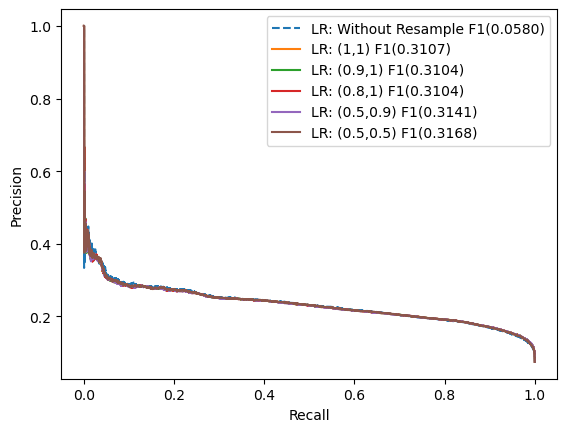

In [315]:
plot_precision_recall_curve(models_info_resampling_lr)

### Random Forest: Resample (?, ?)

In [205]:
models_info_resampling_rf, best_resample_rf_model = tuning_resample_portion(X_train_scaled, y_train, X_cv_scaled, y_cv, model_type='rf')

Processing - RF: Without Resample
Top F1 updated:  0.005102806543598981
F1 : 0.005102806543598981
Processing - RF with (1, 1)
Top F1 updated:  0.22223982258830985
F1 : 0.22223982258830985
Processing - RF with (0.9, 1)
Top F1 updated:  0.23586715867158672
F1 : 0.23586715867158672
Processing - RF with (0.8, 1)
Top F1 updated:  0.2547546531302876
F1 : 0.2547546531302876
Processing - RF with (0.5, 0.9)
Top F1 updated:  0.2865581869931798
F1 : 0.2865581869931798
Processing - RF with (0.5, 0.5)
F1 : 0.15752230540457388
tuning_resample_portion - finished


In [207]:
y_pred = best_resample_rf_model.predict(X_cv_scaled)
print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.40      0.29      6622
           1       0.95      0.89      0.92     82368

    accuracy                           0.85     88990
   macro avg       0.59      0.64      0.60     88990
weighted avg       0.89      0.85      0.87     88990



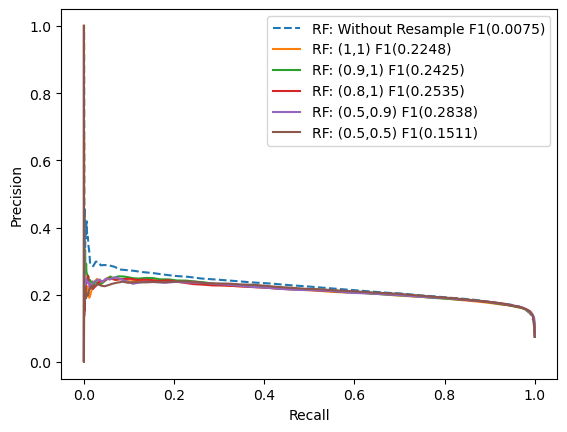

In [53]:
plot_precision_recall_curve(models_info_resampling_rf)

### XGBClassifier: Resample (?, ?)

In [206]:
models_info_resampling_xgb, best_resample_xgboost_model = tuning_resample_portion(X_train_scaled, y_train, X_cv_scaled, y_cv, model_type='xgb')

Processing - XGB: Without Resample
Top F1 updated:  0.02159443869250111
F1 : 0.02159443869250111
Processing - XGB with (1, 1)
Top F1 updated:  0.11832154183947305
F1 : 0.11832154183947305
Processing - XGB with (0.9, 1)
Top F1 updated:  0.14509213118553713
F1 : 0.14509213118553713
Processing - XGB with (0.8, 1)
Top F1 updated:  0.16657522221002963
F1 : 0.16657522221002963
Processing - XGB with (0.5, 0.9)
Top F1 updated:  0.2273645546372819
F1 : 0.2273645546372819
Processing - XGB with (0.5, 0.5)
F1 : 0.0844617240917013
tuning_resample_portion - finished


In [208]:
y_pred = best_resample_xgboost_model.predict(X_cv_scaled)
print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.19      0.23      6622
           1       0.94      0.96      0.95     82368

    accuracy                           0.91     88990
   macro avg       0.61      0.58      0.59     88990
weighted avg       0.89      0.91      0.90     88990



From above experiment model we got several finding:
- Resampling does help model to perform better in classifying minority class, if we compared with base model without resample
- The portion of under and oversampling slightly affect the F1 score
- the best portion for sampling_strategy we found is really depends on the model, on logistic (0.5, 0,5) is the best, while rf (0.5, 0.9) is the best
- the (0.5, 0.5) portion is perform worst on rf: resample model, this might indicate that the portion is not stable, 

Conclusion:
We choose (0.5, 0.9) because it perform well on logistic, random forest and XGB

### What to do next
1. Try more complex model like Neural Network, and decide which model are the best based on specific metrics like F1 score
2. Hyperparameter Tuning
3. Feature Engineering (Add polynomial and any combination features)

Let's make a recap based on our current progress, we will get model name and F1-score of each model with (0.5, 0.9) resample data

In [40]:
models_info = pd.DataFrame({'model name': ['Logistic Regression', 'Random Forest', 'XGBoost'], 'F1-score': ['0.3132', '0.2872', '0.2334']})
models_info

,model name,F1-score
0,Logistic Regression,0.3132
1,Random Forest,0.2872
2,XGBoost,0.2334


### Resample training data with (0.5, 0.9)

In [41]:
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.9)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train_resample, y_train_resample = pipeline.fit_resample(X_train_scaled, y_train)

### Neural Network

In [216]:
tf.random.set_seed(42)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(13,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid', name = 'OutputLayer')
     ]
)

In [217]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                448       
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 OutputLayer (Dense)         (None, 1)                 17        
                                                                 
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


### Create F1 Score Custom Function
This is because f1 score is not available in tf.keras.metrics so we need to create it ourself

In [43]:
# Create a precision metric
precision = tf.keras.metrics.Precision(name='precision')
# Create a recall metric
recall = tf.keras.metrics.Recall(name='recall')

# Define a custom F1 score metric
class F1Score_custom(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score_custom, self).__init__(name=name, **kwargs)
        self.f1_score = self.add_weight(name='f1_score', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        precision.update_state(y_true, y_pred, sample_weight)
        recall.update_state(y_true, y_pred, sample_weight)
        p = precision.result()
        r = recall.result()
        self.f1_score.assign((2 * p * r) / (p + r + 1e-7))

    def result(self):
        return self.f1_score

    def reset_state(self):
        precision.reset_state()
        recall.reset_state()
        self.f1_score.assign(0.0)

# Create an instance of the custom F1 score metric
f1_score = F1Score_custom()

In [228]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics = ['accuracy', precision, recall, f1_score])

In [229]:
history = model.fit(x=X_train_resample, y=y_train_resample, batch_size=32, epochs=10, validation_data=(X_cv_scaled, y_cv))

Epoch 1/10
8151/8151 [==============================] - 34s 4ms/step - loss: 0.4320 - accuracy: 0.7893 - precision: 0.8972 - recall: 0.6772 - f1_score: 0.7718 - val_loss: 0.4533 - val_accuracy: 0.6955 - val_precision: 0.9857 - val_recall: 0.6809 - val_f1_score: 0.8054
Epoch 2/10
8151/8151 [==============================] - 38s 5ms/step - loss: 0.4302 - accuracy: 0.7901 - precision: 0.8972 - recall: 0.6790 - f1_score: 0.7730 - val_loss: 0.4516 - val_accuracy: 0.6997 - val_precision: 0.9853 - val_recall: 0.6857 - val_f1_score: 0.8087
Epoch 3/10
8151/8151 [==============================] - 31s 4ms/step - loss: 0.4290 - accuracy: 0.7911 - precision: 0.8971 - recall: 0.6813 - f1_score: 0.7744 - val_loss: 0.4525 - val_accuracy: 0.6986 - val_precision: 0.9850 - val_recall: 0.6848 - val_f1_score: 0.8079
Epoch 4/10
8151/8151 [==============================] - 40s 5ms/step - loss: 0.4283 - accuracy: 0.7919 - precision: 0.8978 - recall: 0.6823 - f1_score: 0.7754 - val_loss: 0.4640 - val_accuracy:

In [230]:
# Import the classification_report function
from sklearn.metrics import classification_report

# Generate the predicted labels
y_pred = model.predict(X_cv_scaled)

# Create a boolean array indicating which elements are greater than 0.5
condition = y_pred > 0.5
# Use the boolean array to select the elements and set them to 1
y_pred[condition] = 1
# Use the boolean array to select the elements that are not greater than 0.5 and set them to 0
y_pred[~condition] = 0

# Generate the classification report
report = classification_report(y_cv, y_pred)

# Print the report
print(report)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2781/2781 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.18      0.88      0.30      6622
           1       0.99      0.67      0.80     82368

    accuracy                           0.69     88990
   macro avg       0.58      0.78      

In [225]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics = ['accuracy', 'loss', 'precision','recall', 'f1_score', 'f1_score_negative']

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == 'accuracy':
#             plt.ylim([0.990, 0.992])
#         elif metric == 'loss':
#             plt.ylim([0.03, 0.06])
#         elif metric == 'precision_1':
#             plt.ylim([0.8, 1.0])
#         elif metric == 'recall_1':
#             plt.ylim([0.3, 0.5])
#         else:
#             plt.ylim([0.0, 1.0])

        plt.legend()

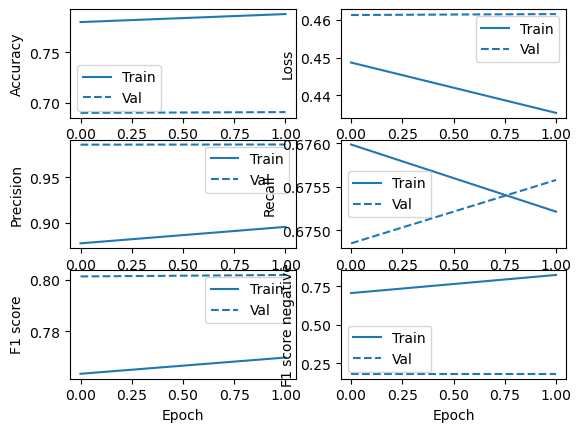

In [226]:
plot_metrics(history)

In [42]:
neural_network_data = pd.DataFrame({'model name': ['Neural Network'], 'F1-score': ['0.3000']})
neural_network_data

,model name,F1-score
0,Neural Network,0.3000


### Learning Recap
From 4 different model, Logistic Regression produce the highest result for predicting minority class (0), with the second highest neural network. 

In [43]:
models_info = pd.concat([models_info, neural_network_data], ignore_index=True)
models_info

,model name,F1-score
0,Logistic Regression,0.3132
1,Random Forest,0.2872
2,XGBoost,0.2334
3,Neural Network,0.3000


### Feature Engineering (Polynomial Features)

having degree polynomial will produce more complex model to capture more complex relationship in our data. The problem of polynomial feature is it's vulnerable to overfitting, but we can use regularization to minimize the effect

In [45]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [254]:
train_errors = []
val_errors = []

# Iterate over polynomial degrees
for degree in range(1, 5):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train_resample)
    X_poly_val = poly.transform(X_cv_scaled)
    
     # Create and fit LinearRegression model
    model = LogisticRegression()
    model.fit(X_poly_train, y_train_resample)

    # Predict and calculate mean squared error
    y_train_pred = model.predict(X_poly_train)
    y_val_pred = model.predict(X_poly_val)
    train_mse = mean_squared_error(y_train_resample, y_train_pred)
    val_mse = mean_squared_error(y_cv, y_val_pred)

    train_errors.append((degree, train_mse))
    val_errors.append((degree, val_mse))

C:\Users\ASUS\anaconda3\envs\fachryds\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\envs\fachryds\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

### What is the good number of polynomial degree?
When we're talking about polynomial degree, it's a trade-off between accuracy and complexity of the model. in this case three offers complexity with reasonable amount of error

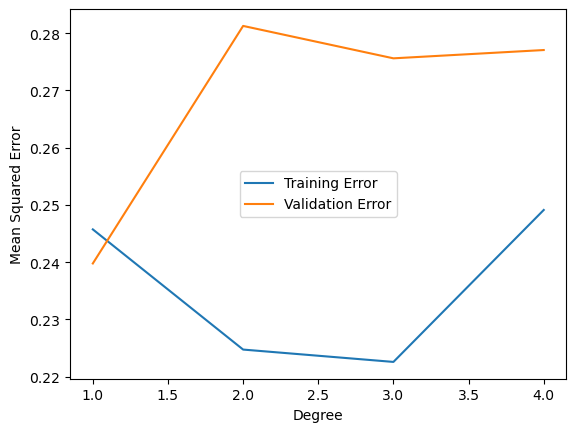

In [255]:
# Plot training vs validation error
train_errors = np.array(train_errors)
val_errors = np.array(val_errors)

fig, ax = plt.subplots()
ax.plot(train_errors[:,0], train_errors[:,1], label='Training Error')
ax.plot(val_errors[:,0], val_errors[:,1], label='Validation Error')
ax.legend()
ax.set_xlabel('Degree')
ax.set_ylabel('Mean Squared Error')
plt.show()

Now let's train logistic regression using polynomial data with regularization

In [46]:
# Create polynomial features with 3 degree
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train_resample)
X_poly_val = poly.transform(X_cv_scaled)

 # Create and fit LinearRegression model
model = LogisticRegression(penalty='l2', C=1.0)
model.fit(X_poly_train, y_train_resample)

y_pred = model.predict(X_poly_val)
print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.82      0.30      6622
           1       0.98      0.71      0.82     82368

    accuracy                           0.72     88990
   macro avg       0.58      0.77      0.56     88990
weighted avg       0.92      0.72      0.79     88990



C:\Users\ASUS\anaconda3\envs\tf2.8\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Hyperparameter Tuning

In [47]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [52]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

### Neural Network: Tuning
- Try bigger architecture
- Add regularization, normalization or dropout to prevent overfitting
- Tune epochs and batch_size

#### Prepare the data

In [326]:
X_poly_train.shape

(347773, 560)

In [338]:
tf.random.set_seed(42)  # applied to achieve consistent results
model_nn_tuning = Sequential(
    [
        tf.keras.Input(shape=(X_poly_train.shape[1],)),
        Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid', name = 'OutputLayer')
     ]
)

In [339]:
model_nn_tuning.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 64)                35904     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 32)                2080      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_44 (Dense)            (None, 16)                528       
                                                                 
 OutputLayer (Dense)         (None, 1)                 17        
                                                                 
Total params: 38,529
Trainable params: 38,529
Non-tra

In [340]:
model_nn_tuning.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics = ['accuracy', precision, recall, f1_score])

In [341]:
history = model_nn_tuning.fit(x=X_poly_train, 
                              y=y_train_resample, 
                              batch_size=32, epochs=10, 
                              validation_data=(X_poly_val, y_cv),
                              class_weight = {0: 2.000, 1: 1.000})

Epoch 1/10
10868/10868 [==============================] - 49s 4ms/step - loss: 0.8698 - accuracy: 0.7666 - precision: 0.9373 - recall: 0.5964 - f1_score: 0.7290 - val_loss: 0.6228 - val_accuracy: 0.6448 - val_precision: 0.9918 - val_recall: 0.6214 - val_f1_score: 0.7641
Epoch 2/10
10868/10868 [==============================] - 43s 4ms/step - loss: 0.5966 - accuracy: 0.7771 - precision: 0.9458 - recall: 0.6115 - f1_score: 0.7428 - val_loss: 0.6435 - val_accuracy: 0.6438 - val_precision: 0.9920 - val_recall: 0.6202 - val_f1_score: 0.7632
Epoch 3/10
10868/10868 [==============================] - 44s 4ms/step - loss: 0.5868 - accuracy: 0.7809 - precision: 0.9470 - recall: 0.6183 - f1_score: 0.7481 - val_loss: 0.6455 - val_accuracy: 0.6519 - val_precision: 0.9912 - val_recall: 0.6295 - val_f1_score: 0.7700
Epoch 4/10
10868/10868 [==============================] - 43s 4ms/step - loss: 0.5805 - accuracy: 0.7831 - precision: 0.9490 - recall: 0.6213 - f1_score: 0.7510 - val_loss: 0.6341 - val_a

In [343]:
# Import the classification_report function
from sklearn.metrics import classification_report

# Generate the predicted labels
y_pred = model_nn_tuning.predict(X_poly_val)

# Create a boolean array indicating which elements are greater than 0.5
# or usually people call this a mask
condition = y_pred > 0.5
# Use the boolean array to select the elements and set them to 1
y_pred[condition] = 1
# Use the boolean array to select the elements that are not greater than 0.5 and set them to 0
y_pred[~condition] = 0

# Generate the classification report
report = classification_report(y_cv, y_pred)

# Print the report
print(report)
print("Precision:", precision_score(y_cv, y_pred, pos_label=0))
print("Recall:", recall_score(y_cv, y_pred, pos_label=0))
print("F1:", f1_score(y_cv, y_pred, pos_label=0))
print("Area under precision (AUC) Recall:", average_precision_score(y_cv, y_pred, pos_label=0))

2781/2781 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.17      0.92      0.28      6622
           1       0.99      0.63      0.77     82368

    accuracy                           0.65     88990
   macro avg       0.58      0.78      0.52     88990
weighted avg       0.93      0.65      0.73     88990

Precision: 0.16597094220969316
Recall: 0.9246451223195409
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\envs\fachryds\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_22400\1380495084.py", line 22, in <module>
    print("F1:", f1_score(y_cv, y_pred, pos_label=0))
  File "C:\Users\ASUS\anaconda3\envs\fachryds\lib\site-packages\keras\metrics\base_metric.py", line 213, in __call__
    return distributed_training_utils.call_replica_local_fn(
  File "C:\Users\ASUS\anaconda3\envs\fachryds\lib\site-packages\keras\distribute\distributed_training_utils.py", line 60, in call_replica_local_fn
    return fn(*args, **kwargs)
  File "C:\Users\ASUS\anaconda3\envs\fachryds\lib\site-packages\keras\metrics\base_metric.py", line 190, in replica_local_fn
    update_op = self.update_state(*args, **kwargs)
  File "C:\Users\ASUS\anaconda3\envs\fachryds\lib\site-packages\keras\utils\metrics_utils.py", line 77, in de

### Logistic Regression: Tuning

In [58]:
models_info

,model name,F1-score
0,Logistic Regression,0.3132
1,Random Forest,0.2872
2,XGBoost,0.2334
3,Neural Network,0.3000


In [49]:
X_poly_train.shape

(347773, 105)

In [ ]:
lr_tuning = LogisticRegression(random_state=42)
param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'fit_intercept': [True, False],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
        'max_iter': [100, 200, 500, 1000]}

clf_lr_tuning = RandomizedSearchCV(lr_tuning, param_distributions = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr_tuning = clf_lr_tuning.fit(X_poly_train,y_train_resample)

In [53]:
clf_performance(best_clf_lr_tuning,'Logistic Regression')

y_pred = best_clf_lr_tuning.predict(X_poly_val)
y_predtrain = best_clf_lr_tuning.predict(X_poly_train)
CM_LR = confusion_matrix(y_cv,y_pred)
CR_LR = classification_report(y_cv,y_pred)
print("Training Accuracy:", accuracy_score(y_train_resample, y_predtrain))
print("Validation Accuracy:", accuracy_score(y_cv, y_pred))
print("Confusion Matrix:\n",CM_LR)
print("Classification Report:\n",CR_LR)

print("F1:", f1_score(y_cv, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_cv, y_pred))

Best Score: 0.7741371667110801
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1000, 'fit_intercept': True, 'C': 100}
Training Accuracy: 0.7746317281675116
Validation Accuracy: 0.7187886279357231
Confusion Matrix:
 [[ 5415  1207]
 [23818 58550]]
Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.82      0.30      6622
           1       0.98      0.71      0.82     82368

    accuracy                           0.72     88990
   macro avg       0.58      0.76      0.56     88990
weighted avg       0.92      0.72      0.79     88990

F1: tf.Tensor(0.8239226, shape=(), dtype=float32)
Area under precision (AUC) Recall: 0.9641245892153532


In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = CM_LR, display_labels = [True, False])
cm_display.plot()

### Random Forest: Tuning

In [48]:
X_train_resample.shape

(347773, 13)

In [ ]:
rf_tuning = RandomForestClassifier(random_state=42)
param_grid =  {'n_estimators': [100,200, 300, 400],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10], 
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}

clf_rf = RandomizedSearchCV(rf_tuning, param_distributions= param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_resample,y_train_resample)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
clf_performance(best_clf_rf,'Random Forest')
y_pred = best_clf_lr_tuning.predict(X_cv_scaled)
y_predtrain = best_clf_lr_tuning.predict(X_train_resample)
CM_LR = confusion_matrix(y_cv,y_pred)
CR_LR = classification_report(y_cv,y_pred)
print("Training Accuracy:", accuracy_score(y_train_resample, y_predtrain))
print("Validation Accuracy:", accuracy_score(y_cv, y_pred))
print("Confusion Matrix:\n",CM_LR)
print("Classification Report:\n",CR_LR)
print("F1:", f1_score(y_cv, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_cv, y_pred))

### XGBoost: Tuning

In [ ]:
xgb = XGBClassifier(random_state=42)

param = {
    'n_estimators': [20, 50, 100, 250, 500,1000],
    'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
    'max_depth': [2, 5, 10, 15, 20, 25, None],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'subsample': [0.5,0.6,0.7, 0.8, 0.9],
    'learning_rate':[.01,0.1,0.2,0.3,0.5, 0.7, 0.9],
    'gamma':[0,.01,.1,1,10,100],
    'min_child_weight':[0,.01,0.1,1,10,100],
    'sampling_method': ['uniform', 'gradient_based']
}
                                  
clf_xgb = RandomizedSearchCV(xgb, param_distributions= param, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scale,y_train)

In [ ]:
clf_performance(best_clf_xgb,'XGB')
y_pred = best_clf_xgb.predict(X_cv_scaled)
y_predtrain = best_clf_xgb.predict(X_train_resample)
CM_LR = confusion_matrix(y_cv,y_pred)
CR_LR = classification_report(y_cv,y_pred)
print("Training Accuracy:", accuracy_score(y_train_resample, y_predtrain))
print("Validation Accuracy:", accuracy_score(y_cv, y_pred))
print("Confusion Matrix:\n",CM_LR)
print("Classification Report:\n",CR_LR)
print("F1:", f1_score(y_cv, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_cv, y_pred))